# CO2 Flux Decomposition for the CalCS PDO

This script performs the CO2 flux decomposition for the onshore and offshore boxes of the CalCS, since a dipole forms spatially. The boxes were determined in the script in this folder `CalCS_Nino34_Subboxes`.

I am attemping to perform the whole decomposition here, so that I don't clog up my filespace with "CalCS Subbox" .ncs.

In [122]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')
import seaborn as sns
from esmtools.physics import stress_to_speed
from esmtools.carbon import co2_sol, schmidt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import esmtools as et

In [123]:
"""
Some constants that are pertinent for this.
"""
a = 6.972e-7 # Flux coefficient in s/m
conversion = (60 * 60 * 24 * 365) / 1e3 # Applied to every term of the expansion to have proper units (see notes)
S0 = 35 # Salinity constant
colors = {'onshore': '#71B0D3', 'offshore': '#F8BB9E'}

In [124]:
b = 'onshore'
x = 'NPGO'
smooth = 12

## Load in Ensemble Means (for sensitivities)

In [126]:
def load_ensemble_mean(b, v):
    """
    Loads in the ensemble mean time series for a given box (b) [onshore/offshore]
    within the California Current for a given variable (v).
    """
    filepath = ('/glade/p/work/rbrady/EBUS_BGC_Variability/CalCS_Boxes/' +
                b.lower() + '/' + v + '/CalCS.' + v + '.' + b.lower() + '.forced-signal.nc')
    da = xr.open_dataarray(filepath)
    da.name = v
    return da

In [127]:
variables = ['FG_CO2', 'SST', 'SALT', 'DIC', 'ALK', 'sDIC', 
             'sALK', 'U', 'DCO2STAR', 'RHO', 'pCO2SURF']
forced = xr.Dataset()
for i, name in enumerate(variables):
    da = load_ensemble_mean(b, name)
    forced = xr.merge([forced, da])

In [128]:
forced = forced.rename({'pCO2SURF': 'pCO2'})
means = forced.mean()

## Load in the Regression Results

In [151]:
def load_regression(b, x, y, smooth):
    """
    Loads in the regression results for a given box (b) [offshore/onshore] of
    the California Current using predictor variable (x) and dependent variable (y).
    """
    filepath = ('/glade/p/work/rbrady/EBUS_BGC_Variability/CalCS_Boxes/' + b.lower() +
                '/regression_results/' + y + '/' + x + '/')
    if smooth == 0:
        filename = (x + '.' + y + '.' + b.lower() + '.unsmoothed.regression.lag0.nc')
    else:
        filename = (x + '.' + y + '.' + b.lower() + '.smoothed' + str(smooth) + '.regression.lag0.nc')
    ds = xr.open_dataset(filepath + filename)
    return ds

In [152]:
delta_FG_CO2 = load_regression(b, x, 'FG_CO2', smooth)
delta_U = load_regression(b, x, 'U', smooth)
delta_SST = load_regression(b, x, 'SST', smooth)
delta_SALT = load_regression(b, x, 'SALT', smooth)
delta_sDIC = load_regression(b, x, 'sDIC', smooth)
delta_sALK = load_regression(b, x, 'sALK', smooth)

In [153]:
"""
tolerance = 0.1
np.where((delta_FG_CO2['p'] <= tolerance) & 
         (delta_U['p'] <= tolerance) &
         (delta_SST['p'] <= tolerance) &
         (delta_SALT['p'] <= tolerance) &
         (delta_sDIC['p'] <= tolerance) &
         (delta_sALK['p'] <= tolerance))
"""
# Seems impossible to get all 34 members to be significant in all terms. So maybe just
# test significance of FG_CO2?
tolerance = 0.1
delta_U = delta_U.where(delta_FG_CO2['p'] <= tolerance, drop=True)
delta_SST = delta_SST.where(delta_FG_CO2['p'] <= tolerance, drop=True)
delta_SALT = delta_SALT.where(delta_FG_CO2['p'] <= tolerance, drop=True)
delta_sDIC = delta_sDIC.where(delta_FG_CO2['p'] <= tolerance, drop=True)
delta_sALK = delta_sALK.where(delta_FG_CO2['p'] <= tolerance, drop=True)
delta_FG_CO2 = delta_FG_CO2.where(delta_FG_CO2['p'] <= tolerance, drop=True)
N = len(delta_FG_CO2['m'])

## Compute Terms

In [154]:
# Repetitive terms
Sc = schmidt(forced['SST'])
ff = co2_sol(forced['SST'], forced['SALT'])
gamma_DIC = (3*means['ALK']*means['DIC'] - 2*means['DIC']**2) / \
            ((2*means['DIC']-means['ALK'])*(means['ALK']-means['DIC']))
gamma_ALK = (-means['ALK']**2)/((2*means['DIC']-means['ALK'])*(means['ALK']-means['DIC']))
dFdpCO2 = means['RHO']*ff*a*np.sqrt(660/Sc)*means['U']**2
dpCO2dDIC = (means['pCO2']*gamma_DIC)/means['DIC']
dpCO2dALK = (means['pCO2']*gamma_ALK)/means['ALK']

""" 
The conversion term converts to the proper mol/m2/yr for every unit. So that we actually have each term
summing to a mol/m2/yr perturbation from some climate event.

Can run a np.where command on the original delta datasets to drop non-significant results.
"""
F = delta_FG_CO2['m']
U = -2*a*np.sqrt(660/Sc)*means['U']*means['DCO2STAR']*delta_U['m']*conversion
SST = dFdpCO2*0.0423*means['pCO2']*delta_SST['m']*conversion
SALT = dFdpCO2*(means['pCO2']/means['SALT'])*delta_SALT['m']*conversion
sDIC = dFdpCO2*dpCO2dDIC*(means['SALT']/S0)*delta_sDIC['m']*conversion
sALK = dFdpCO2*dpCO2dALK*(means['SALT']/S0)*delta_sALK['m']*conversion

# Freshwater
term1 = dFdpCO2*dpCO2dDIC*(means['sDIC']/S0)*delta_SALT['m']*conversion
term2 = dFdpCO2*dpCO2dALK*(means['sALK']/S0)*delta_SALT['m']*conversion
FW = term1 + term2

## Visualize.

In [155]:
def setup_dataframe(v, da):
    """
    Creates a DataFrame with term values given a variable name (v) and the
    DataArray containing the expansion results (da).
    """
    da.name = v
    df = da.to_dataframe()
    return df

In [156]:
variables = ['U','SST','SALT','sDIC','sALK','FW']
df = pd.DataFrame()
for i, name in enumerate(variables):
    temp_df = setup_dataframe(name, eval(name))
    df = pd.concat([df, temp_df], axis=1)
df['Total'] = df.sum(axis=1)

In [157]:
# For putting the variance explained.
avg_r = delta_FG_CO2['r'].median()
avg_r = avg_r.values

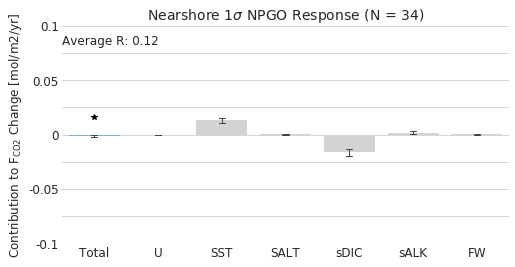

In [158]:
# Set up colors
clist = [colors[b], '#d3d3d3', '#d3d3d3', '#d3d3d3', '#d3d3d3', '#d3d3d3', '#d3d3d3']

# Set up plot
sns.set_style('whitegrid')
order = list(['Total', 'U', 'SST', 'SALT', 'sDIC', 'sALK', 'FW'])
f, ax = plt.subplots(figsize=(8,4))
bars = sns.barplot(data=df, ax=ax, ci=95, capsize=0.1, errwidth=1,
                   palette=clist, order=order)
plt.plot(0, F.mean(), '*k')
sns.despine(left=True, bottom=True)

# Aesthetics
#ax.set_title(b.title() + ' ' + x + ' (N = ' + str(N) + ')', fontsize=14)
ax.set_title('Nearshore 1$\sigma$' + ' ' + x + ' Response (N = ' + str(N) + ')', fontsize=14)
ax.set_ylim([-0.1,0.1])
labels=['-0.1','','-0.05','','0','','0.05','','0.1']
#labels=['-0.4','','-0.2','','0','','0.2','','0.4']
ax.set_yticklabels(labels)
ax.set_ylabel('Contribution to F$_{\mathrm{CO}2}$ Change [mol/m2/yr]',
              fontsize=12)

# Add variance explained.
plt.text(-0.5, 0.083, 'Average R: ' + str(avg_r.round(2)), fontsize=12)

# Fontsizes
ax.tick_params(labelsize=12)

plt.show()